# Read SMILES for the 20k LINCS molecules

### Uses enviroment ase py2.7.11 + cmappy 3.2.0 + ipykernel

In [1]:
import platform
platform.python_version()

'2.7.11'

In [2]:
import numpy as np
import pandas as pd
import cmapPy
import pkg_resources
from cmapPy.pandasGEXpress.parse import parse
import random
from random import sample
from scipy import spatial
pkg_resources.get_distribution("cmappy").version


/home/jgmeyer2/anaconda3/envs/my_cmapPy_env/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'3.2.0'

##### Read the signatureinformation spreadsheet as a pandas dataframe

In [3]:
sig_info = pd.read_csv('/media/jgmeyer2/u/LINCS/GSE92742_Broad_LINCS_sig_info.txt', sep="\t", low_memory=False)
print(sig_info.columns)  ### print the column names
sig_info.head(n=5)

Index([u'sig_id', u'pert_id', u'pert_iname', u'pert_type', u'cell_id',
       u'pert_dose', u'pert_dose_unit', u'pert_idose', u'pert_time',
       u'pert_time_unit', u'pert_itime', u'distil_id'],
      dtype='object')


,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_time_unit,pert_itime,distil_id
0,AML001_CD34_24H:A05,DMSO,DMSO,ctl_vehicle,CD34,0.1,%,0.1 %,24,h,24 h,AML001_CD34_24H_X1_F1B10:A05
1,AML001_CD34_24H:A06,DMSO,DMSO,ctl_vehicle,CD34,0.1,%,0.1 %,24,h,24 h,AML001_CD34_24H_X3_F1B10:A06
2,AML001_CD34_24H:B05,DMSO,DMSO,ctl_vehicle,CD34,0.1,%,0.1 %,24,h,24 h,AML001_CD34_24H_X1_F1B10:B05|AML001_CD34_24H_X...
3,AML001_CD34_24H:B06,DMSO,DMSO,ctl_vehicle,CD34,0.1,%,0.1 %,24,h,24 h,AML001_CD34_24H_X3_F1B10:B06
4,AML001_CD34_24H:BRD-A03772856:0.37037,BRD-A03772856,BRD-A03772856,trt_cp,CD34,0.37037,µM,500 nM,24,h,24 h,AML001_CD34_24H_X1_F1B10:J04|AML001_CD34_24H_X...


In [4]:
len(sig_info.columns.)

SyntaxError: invalid syntax (<ipython-input-4-6130b74f5246>, line 1)

#### get subset matrix for ONLY MCF7

In [5]:

sig_subset = sig_info[sig_info["cell_id"] == "MCF7"]
print(len(sig_subset))

63367



### from the MCF7 or VCAP cell lines, take only those that:

1. pert_type == trt_cp  (64065 total) | pert_type == ctl_vehicle  (4798 total)
2. pert_itime == 24 h
3. pert_idose" == "5 µM" "10 µM" "0.1 %"

DMSO included as blank picture

In [6]:
veh_trt_array = np.asarray(sig_subset["pert_type"] == "trt_cp")
veh_trt_subset = sig_subset[veh_trt_array]
print(len(veh_trt_subset))

29312


In [7]:
itime_subset = veh_trt_subset[veh_trt_subset["pert_itime"] == "24 h"]
print(len(itime_subset))

17596


In [8]:
### 5 uM and 10 uM
#idose_array = np.asarray(itime_subset["pert_idose"] == "5 µM") | np.asarray(itime_subset["pert_idose"] ==   "10 µM" )
#idose_subset = itime_subset[idose_array ]
#print(len(idose_subset))

13434


In [9]:
### only 10 uM
idose_subset = itime_subset[itime_subset["pert_idose"] ==   "10 µM" ]
print(len(idose_subset))

8419


In [10]:
#idose_subset = itime_subset[itime_subset["pert_idose"] ==   "5 µM" ]
#print(len(idose_subset))

In [11]:
#set(itime_subset["pert_idose"])  ### what range of values does idose take?

In [12]:
sigIDs = idose_subset["sig_id"] ### 31028

##### Get only the landmark gene row ids

In [13]:
gene_info = pd.read_csv("/media/jgmeyer2/u/LINCS/GSE92742_Broad_LINCS_gene_info.txt", sep="\t", dtype=str)
gene_info.columns
landmark_gene_row_ids = gene_info["pr_gene_id"][gene_info["pr_is_lm"] == "1"]
#landmark_gene_row_ids

#### Parse metadata from gtx

In [14]:
gctxPATH = "/media/jgmeyer2/u/LINCS/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx"

In [15]:
my_col_metadata = parse(gctxPATH, col_meta_only=True)
my_col_metadata[0:5]

chd
cid
CPC005_A375_6H:BRD-A85280935-003-01-7:10
CPC005_A375_6H:BRD-A07824748-001-02-6:10
CPC004_A375_6H:BRD-K20482099-001-01-1:10
CPC005_A375_6H:BRD-K62929068-001-03-3:10
CPC005_A375_6H:BRD-K43405658-001-01-8:10


In [16]:
my_row_metadata = parse(gctxPATH, row_meta_only=True)
my_row_metadata[0:5]

rhd
rid
5720
466
6009
2309
387


### Make gctoo object with only above cids and only landmark gene rows

In [17]:
temp_gctoo = parse( gctxPATH, cid=sigIDs, rid = landmark_gene_row_ids )

In [18]:
# Check to make sure we have (978 x 8419 columns) of expression data
# 5uM + 10 uM == 13434 compounds
# 5 uM = 5015 compounds
# 10 uM = 8419 matching, 

temp_gctoo.data_df.shape #

(978, 8419)

### Save the instance of my gctoo subset

In [22]:
import cmapPy.pandasGEXpress.write_gctx as wg

###### Write 5uM + 10 uM

In [23]:
#wg.write(temp_gctoo, "MCF7_24h_5uM_10uM_978x13434")

##### Write 5 uM

In [ ]:
#wg.write(noDMSO_gctoo, "MCF7_24h_5uM_978x5015")

##### Write 10 uM

In [33]:
wg.write(noDMSO_gctoo, "MCF7_24h_10uM_978x8419")

# Start here with pre-filtered gctx

### Read the saved gctx - MCF7_24h

In [21]:
PATH = "MCF7_24h_10uM_978x8419.gctx"

In [22]:
noDMSO_gctoo = parse(PATH, make_multiindex=False)  ### excluding DMSO

# Map the columns to their compound identity
compound identity is the part "BRD-A07824748"

Preceded by a colon and exactly 16 characters?

In [23]:
my_col_metadata = parse(PATH, col_meta_only=True)
my_col_metadata[0:5]

chd
cid
CPC005_MCF7_24H:BRD-A85280935-003-01-7:10
CPC005_MCF7_24H:BRD-A07824748-001-02-6:10
CPC005_MCF7_24H:BRD-K62929068-001-03-3:10
CPC005_MCF7_24H:BRD-K43405658-001-01-8:10
CPC005_MCF7_24H:BRD-K51223576-001-01-3:10


In [24]:
row_metadata = parse(PATH, row_meta_only=True)
row_metadata[0:5]

rhd
rid
5720
466
6009
2309
387


In [25]:
rids = list(row_metadata.index)

In [26]:
cids = list(my_col_metadata.index)
split1 = [x.split(":")[1] for x in cids]
cleaned_chemids = [x[:13] for x in split1] ## list comprehension, keep only the first 13
print(len(cleaned_chemids))
print("unique chemical treatments")
print(len(set(cleaned_chemids)))
cleaned_chemids[0:5]

8419
unique chemical treatments
6718


['BRD-A85280935',
 'BRD-A07824748',
 'BRD-K62929068',
 'BRD-K43405658',
 'BRD-K51223576']

# Figure out why there are duplicate entries for some compounds

### loop through IDs and record which ones have multiple

In [28]:
### find duplicate columns and figure out why they are there
dups_dict = {}
lengths_dict = {}
brdset = set(cleaned_chemids)

for key in brdset:
    tmp = [col for col in noDMSO_gctoo.data_df.columns if key in col]
    dups_dict[key] = tmp
    lengths_dict[key] = len(tmp)
    
#dups_dict


In [29]:
#### get only the broad ids that have a duplicate
twos = [i for i, x in enumerate(lengths_dict.values()) if x == 2]
print(len(twos))
keys = list(dups_dict.keys())
brdids_twos = [keys[x] for x in twos]


833


In [31]:
dat1 = noDMSO_gctoo.data_df.filter(regex=brdids_twos[0])

In [ ]:
dat2 = dat1
for i in range(1,len(brdids_twos)):
    dat2 = dat2.join(noDMSO_gctoo.data_df.filter(regex=brdids_twos[i]))
#dat2

In [33]:
### get the correlation between pairs of measurements
corr_list = []
for i in range(0,len(dat2.columns),2):
    corr_list.append(dat2.iloc[:,i:i+2].corr().iloc[1,0])

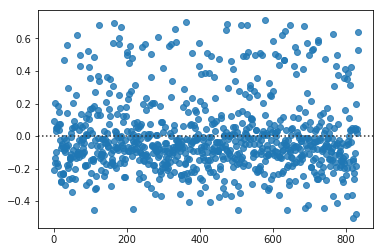

In [37]:
import seaborn as sns
sns.residplot(range(0,833), corr_list)
sns.set()